# **Red Neuronal Recurrente para el pronótico de la TRM**


Javier Arturo Rozo Alzate - jarozoa@eafit.edu.co    
Liceth Cristina Mosquera Galvis - lcmosquerg@eafit.edu.co  
Juan Diego Estrada Perez - jestra15@eafit.edu.co

Programa: Inteligencia Computacional
Docente: 	Santiago Medina Hurtado - smedinah@eafit.edu.co

10 de mayo de 2020<br>

**Importar bibliotecas**

In [123]:
import tensorflow as tf
from math import sqrt

from numpy import concatenate

import numpy as np
import os
import pandas as pd

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import torch
#from torch.autograd import Variable
import torch
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean
print (tf.keras.__version__)
print (pd.__version__)

2.3.0-tf
1.0.3


**Cargar Datos**

In [124]:
df = pd.read_csv('Datos_TRM.csv', header=0, index_col=1)
#dataset.index = dataset['Date Time']
df.index.name = 'date'
df=df.drop(['Index','FF_EfcRate'], axis=1)
df.tail(5)

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
date,,,,,,,,,,,,,,,,
04/24/2020,4020.94,8.299271,0.03706,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,16.94,1735.6,-17.01,-0.004221,4008.944,3990.5985
04/27/2020,4039.87,8.303968,0.03675,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.78,1723.8,18.93,0.004697,4022.306,3988.2750
04/28/2020,4039.83,8.303958,0.03677,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,12.34,1722.2,-0.04,-0.000010,4036.720,3990.4750
04/29/2020,4046.04,8.305494,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,6.21,0.001536,4036.926,3990.6370
04/30/2020,3983.29,8.289863,0.03712,0.038254,0.058496,0.073216,0.01906,0.027594,0.031409,0.25,15.06,1713.4,-62.75,-0.015631,4025.994,3986.5610


In [125]:
df.describe()

,TRM,TRM_logn,IBR,YTES1Y_COP,YTES5Y_COP,YTES10Y_COP,YTES1Y_UVR,YTES5Y_UVR,YTES10Y_UVR,FF_UB,WTI_USD,GOLD_USD,VAR_TRM,VAR_LNTRM,MM_5,MM_20
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,3048.219539,8.018003,0.052413,0.053287,0.063457,0.072009,0.015956,0.027207,0.033723,1.219727,52.163195,1292.769602,1.266305,0.000408,3045.650986,3036.331333
std,286.087760,0.092594,0.012612,0.009529,0.007822,0.007833,0.006387,0.004965,0.004495,0.798633,10.781998,134.213180,26.957999,0.008568,283.565014,274.227040
min,2360.580000,7.766663,0.035160,0.038254,0.050234,0.058742,0.004537,0.015435,0.021375,0.250000,-37.630000,1050.800000,-94.370000,-0.030407,2372.094000,2385.795000
25%,2902.192500,7.973222,0.042540,0.046093,0.058596,0.067309,0.011296,0.024805,0.032274,0.500000,46.437500,1208.050000,-13.947500,-0.004535,2901.454000,2909.559625
50%,3003.065000,8.007389,0.045170,0.048312,0.061477,0.070298,0.014619,0.027179,0.033740,1.250000,52.295000,1271.450000,0.395000,0.000132,3001.658000,3000.484250
75%,3194.892500,8.069309,0.062490,0.062428,0.067033,0.075008,0.020063,0.030237,0.035839,2.000000,59.022500,1334.400000,15.520000,0.005170,3190.723500,3200.109625
max,4153.910000,8.331805,0.077880,0.073609,0.088001,0.096859,0.039636,0.043588,0.045797,2.500000,76.410000,1768.900000,219.020000,0.059307,4110.698000,4031.675000


**Analisis Exploratorio de los datos**

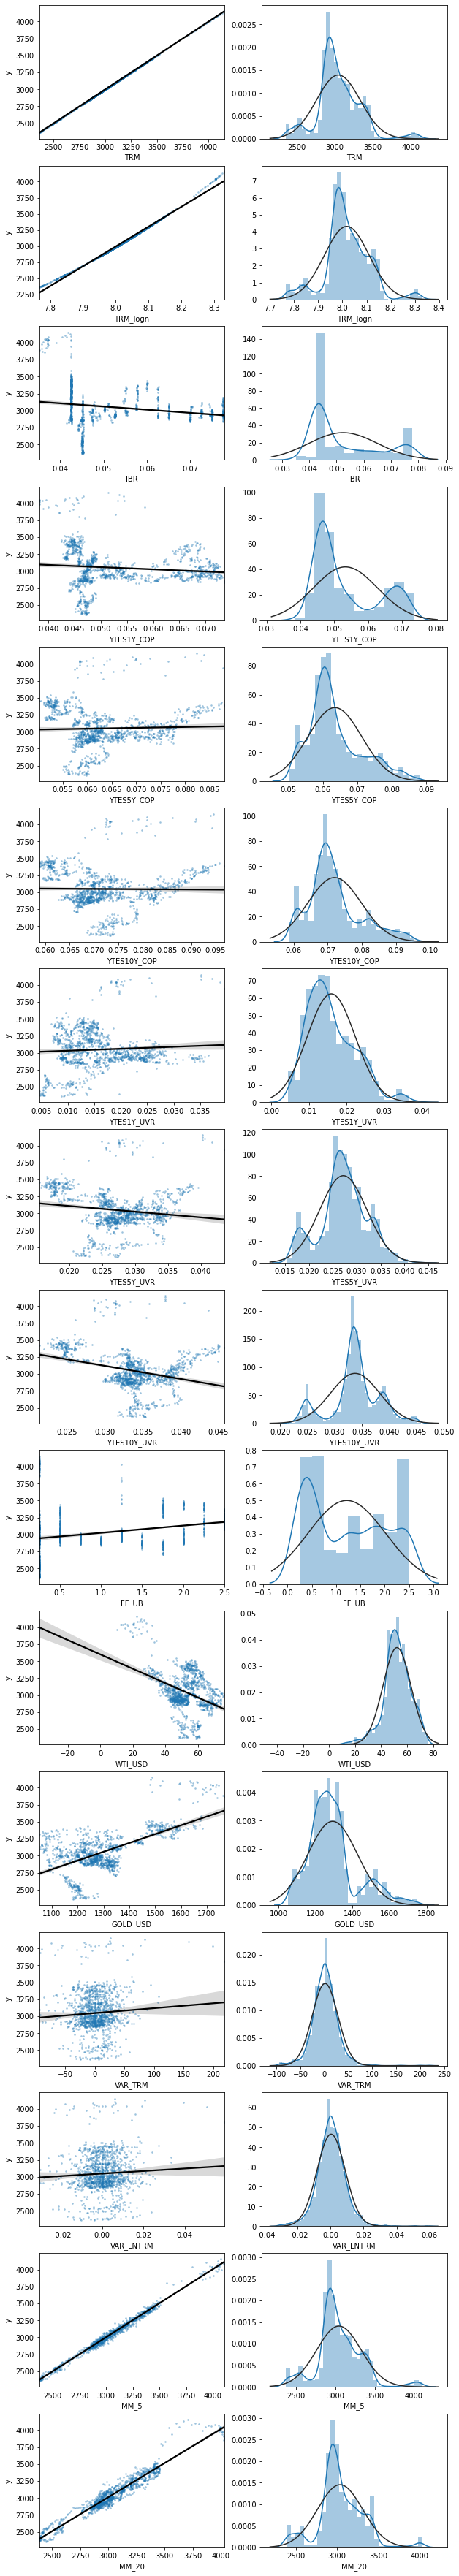

In [126]:
import seaborn as sns
from scipy import stats

df.columns
cols_continuous=['TRM', 'TRM_logn', 'IBR', 'YTES1Y_COP', 'YTES5Y_COP', 
                 'YTES10Y_COP','YTES1Y_UVR', 'YTES5Y_UVR', 'YTES10Y_UVR', 
                 'FF_UB', 'WTI_USD','GOLD_USD', 'VAR_TRM', 'VAR_LNTRM', 
                 'MM_5', 'MM_20']

# figure parameters
fcols = 2
frows = len(cols_continuous)
plt.figure(figsize=(5*fcols,4*frows))

i=0
for col in cols_continuous:
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.regplot(x=col, y='TRM', data=df, ax=ax, 
                scatter_kws={'marker':'.','s':3,'alpha':0.3},
                line_kws={'color':'k'});
    plt.xlabel(col)
    plt.ylabel('y')
    
    i+=1
    ax=plt.subplot(frows,fcols,i)
    sns.distplot(df[col].dropna() , fit=stats.norm)
    plt.xlabel(col)
#import pandas_profiling
#pd.read_csv('Datos_TRM.csv').profile_report() 

Se estandarizan todas las variables (continuas dependientes). Se divide los datos en test y training, se halla la media y la varianza del training y se transforma el test.


In [0]:
C1=16
C2=8
C3=8
EPOCHS=80

In [0]:
Train=df.loc['01/30/2015':'01/08/2019']
Val=df.loc['01/09/2019':'12/31/2019']
Test=df.loc['01/02/2020':'01/10/2020']

In [0]:
Train=Train.values
Train=Train.astype('float32')
Test=Test.values
Test=Test.astype('float32')
Val=Val.values
Val=Val.astype('float32')

In [153]:
scaler=StandardScaler()
Train_sc=scaler.fit_transform(Train)
Test_sc=scaler.transform(Test)
Val_sc=scaler.transform(Val)
Train_df=pd.DataFrame(Train_sc)
Test_df=pd.DataFrame(Test_sc)
Val_df=pd.DataFrame(Val_sc)
print(Train_df.shape)
print(Test_df.shape)
print(Val_df.shape)

(959, 16)
(6, 16)
(239, 16)
(959, 16)
(6, 16)
(239, 16)


In [154]:
# split into input and outputs
train_X, train_y = Train_sc[:, :-1], Train_sc[:, -1]
test_X, test_y = Test_sc[:, :-1], Test_sc[:, -1]
val_X, val_y = Val_sc[:, :-1], Val_sc[:, -1]


# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,val_X.shape,val_y.shape)

(959, 1, 15) (959,) (6, 1, 15) (6,) (239, 1, 15) (239,)
(959, 1, 15) (959,) (6, 1, 15) (6,) (239, 1, 15) (239,)


In [0]:
#conjunto de validación
validation_data = (np.expand_dims(val_X, axis=0),np.expand_dims(val_y, axis=0))

**Definir la red**
Se define como una secuencia de capas en el orden que estna conectadas al final se pone la capa de salida.

**Compilar la red**
Transformar la secuencia de capaz en matrices altamente eficientes. Especificando el algoritmo de optimización para entrenar la red y la funcion de perdida utilizada para evaluar la red que es minimizada por el algoritmo de optimización.

In [156]:
model_lstm=tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(C1,return_sequences=True,
                                    input_shape=(train_X.shape[1],train_X.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=C2,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=C3))
model_lstm.add(tf.keras.layers.Dense(units=1))

model_lstm.compile(loss='mae',optimizer='adam')
model_lstm.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 1, 16)             2048      
_________________________________________________________________
lstm_31 (LSTM)               (None, 1, 8)              800       
_________________________________________________________________
lstm_32 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 1, 16)             2048      
____________________________

**Ajustar la red**
Adaptar pesos al conjunto de datos en fromación, se especifican los datos de formación. La red se forma utilizando el algoritmo de retropropagación y se optimiza de acuerdo con el algoritmo de optimización y la función de pérdida especificados al compilar el modelo.

El algoritmo de retropropagación requiere que la red sea entrenada para un número específico de épocas o exposiciones al conjunto de datos de entrenamiento. Cada época puede dividirse en grupos de pares de patrones input-output llamados lotes. Define el número de patrones a los que se expone la red antes de que se actualicen las ponderaciones dentro de una época




In [157]:
#fit network
history_lstm=model_lstm.fit(train_X,train_y,epochs=EPOCHS,batch_size=5,
                            validation_data=(val_X,val_y),shuffle=False)

Epoch 1/80
192/192 [==============================] - 2s 11ms/step - loss: 0.6834 - val_loss: 1.7093
Epoch 2/80
192/192 [==============================] - 1s 7ms/step - loss: 0.5702 - val_loss: 1.2366
Epoch 3/80
192/192 [==============================] - 1s 6ms/step - loss: 0.4350 - val_loss: 1.2141
Epoch 4/80
192/192 [==============================] - 1s 7ms/step - loss: 0.3635 - val_loss: 1.2505
Epoch 5/80
192/192 [==============================] - 1s 6ms/step - loss: 0.2993 - val_loss: 1.2081
Epoch 6/80
192/192 [==============================] - 1s 7ms/step - loss: 0.2507 - val_loss: 1.1110
Epoch 7/80
192/192 [==============================] - 1s 7ms/step - loss: 0.2339 - val_loss: 1.0209
Epoch 8/80
192/192 [==============================] - 1s 7ms/step - loss: 0.2178 - val_loss: 0.9026
Epoch 9/80
192/192 [==============================] - 1s 7ms/step - loss: 0.2059 - val_loss: 0.8406
Epoch 10/80
192/192 [==============================] - 1s 7ms/step - loss: 0.1914 - val_loss: 0.817

**` Evaluar la red`**

Evaluar el rendimiento de la red en un conjunto de datos separado, no visto durante las pruebas. 


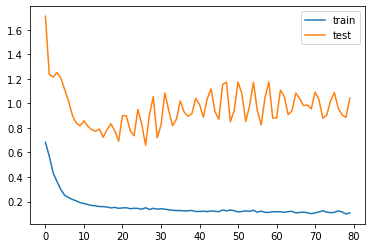

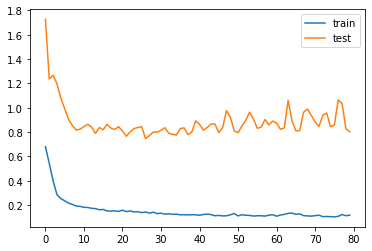

In [158]:
#plotting the training progression
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.show()

**Hacer prediciones**


In [0]:
#make prediction
yhatt=model_lstm.predict(val_X)
xvalt=val_X.reshape((val_X.shape[0],val_X.shape[2]))

#invert scaling for forecast
inv_yhatt=concatenate((yhatt,xvalt),axis=1) #inv_yhat=concatenate((yhat,xtest[:,1:]),axis=1)
inv_yhatt=scaler.inverse_transform(inv_yhatt)
inv_yhatt=inv_yhatt[:,0]

#invert scaling for actual
yvalt=val_y.reshape((len(val_y),1))
inv_yt=concatenate((yvalt,xvalt),axis=1)#inv_y=concatenate((ytest,xtest[:,1:]),axis=1)
inv_yt=scaler.inverse_transform(inv_yt)
inv_yt=inv_yt[:,0]

In [160]:
print("Mean absolute error (MAE):       %f"% mean_absolute_error(inv_yt,inv_yhatt))
print("Mean squared error (MSE):        %f"% mean_squared_error(inv_yt,inv_yhatt))
print("Root Mean squared error (RMSE):  %f"% sqrt(mean_squared_error(inv_yt,inv_yhatt)))
print("R square (R^2):                  %f"% r2_score(inv_yt,inv_yhatt))

Mean absolute error (MAE):       209.866821
Mean squared error (MSE):        63024.886719
Root Mean squared error (RMSE):  251.047579
R square (R^2):                  -3.292923
Mean absolute error (MAE):       161.119186
Mean squared error (MSE):        39228.832031
Root Mean squared error (RMSE):  198.062697
R square (R^2):                  -1.672061


<function matplotlib.pyplot.show>

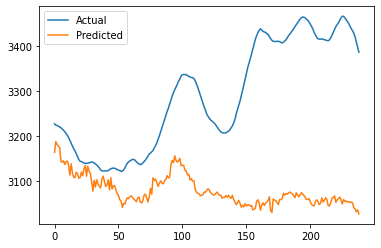

<function matplotlib.pyplot.show>

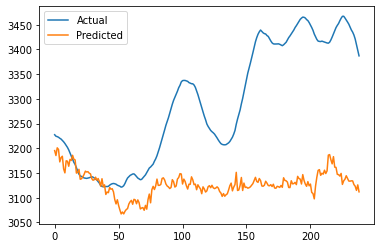

In [161]:
 plt.plot(inv_yt,label='Actual')
 plt.plot(inv_yhatt,label='Predicted')
 plt.legend()
 plt.show

In [162]:
#make prediction
yhatt2=model_lstm.predict(test_X)
xtestt2=test_X.reshape((test_X.shape[0],test_X.shape[2]))

#invert scaling for forecast
inv_yhatt2=concatenate((yhatt2,xtestt2),axis=1) #inv_yhat=concatenate((yhat,xtest[:,1:]),axis=1)
inv_yhatt2=scaler.inverse_transform(inv_yhatt2)
inv_yhatt2=inv_yhatt2[:,0]

#invert scaling for actual
ytestt2=test_y.reshape((len(test_y),1))
inv_yt2=concatenate((ytestt2,xtestt2),axis=1)#inv_y=concatenate((ytest,xtest[:,1:]),axis=1)
inv_yt2=scaler.inverse_transform(inv_yt2)
inv_yt2=inv_yt2[:,0]

print("Mean absolute error (MAE):       %f"% mean_absolute_error(inv_yt2,inv_yhatt2))
print("Mean squared error (MSE):        %f"% mean_squared_error(inv_yt2,inv_yhatt2))
print("Root Mean squared error (RMSE):  %f"% sqrt(mean_squared_error(inv_yt2,inv_yhatt2)))
print("R square (R^2):                  %f"% r2_score(inv_yt2,inv_yhatt2))

Mean absolute error (MAE):       334.840820
Mean squared error (MSE):        112288.562500
Root Mean squared error (RMSE):  335.094856
R square (R^2):                  -381.415622
Mean absolute error (MAE):       246.700607
Mean squared error (MSE):        60954.218750
Root Mean squared error (RMSE):  246.889082
R square (R^2):                  -206.588782


<function matplotlib.pyplot.show>

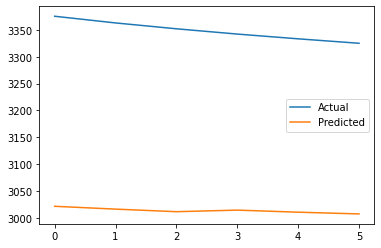

<function matplotlib.pyplot.show>

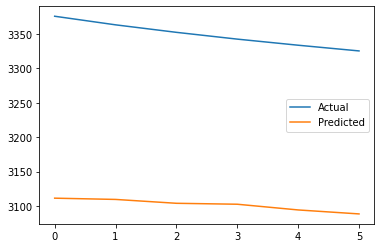

In [163]:
 plt.plot(inv_yt2,label='Actual')
 plt.plot(inv_yhatt2,label='Predicted')
 plt.legend()
 plt.show

**Predicción**

In [164]:
Train2=df.loc['01/30/2015':'12/31/2019']
Test2=df.loc['01/02/2020':'01/10/2020']
Train=Train2.values
Train=Train.astype('float32')
Test=Test2.values
Test=Test.astype('float32')

scaler=StandardScaler()
Train_sc=scaler.fit_transform(Train)
Test_sc=scaler.transform(Test)

Train_df=pd.DataFrame(Train_sc)
Test_df=pd.DataFrame(Test_sc)

print(Train_df.shape)
print(Test_df.shape)

# split into input and outputs
train_X, train_y = Train_sc[:, :-1], Train_sc[:, -1]
test_X, test_y = Test_sc[:, :-1], Test_sc[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1198, 16)
(6, 16)
(1198, 1, 15) (1198,) (6, 1, 15) (6,)
(1198, 16)
(6, 16)
(1198, 1, 15) (1198,) (6, 1, 15) (6,)


In [0]:
Fechastest=Test2.index

In [166]:
model_lstm=tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(C1,return_sequences=True,
                                    input_shape=(train_X.shape[1],train_X.shape[2])))
model_lstm.add(tf.keras.layers.LSTM(units=C2,return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(units=C3))
model_lstm.add(tf.keras.layers.Dense(units=1))

model_lstm.compile(loss='mae',optimizer='adam')
model_lstm.summary()
#
#fit network
history_lstm=model_lstm.fit(train_X,train_y,epochs=EPOCHS,batch_size=5,
                            validation_data=(test_X,test_y),shuffle=False)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 1, 16)             2048      
_________________________________________________________________
lstm_34 (LSTM)               (None, 1, 8)              800       
_________________________________________________________________
lstm_35 (LSTM)               (None, 8)                 544       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 3,401
Trainable params: 3,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
240/240 [==============================] - 2s 10ms/step - loss: 0.7122 - val_loss: 1.1502
Epoch 2/80
240/240 [==============================] - 1s 6ms/step - loss: 0.4103 - val_loss: 0.0721
Epoch 3/80
240/240 [============================

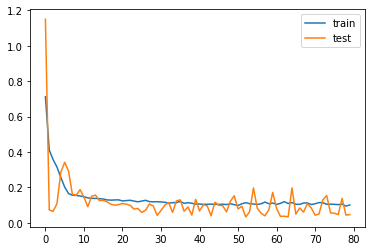

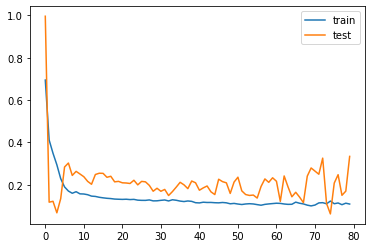

In [167]:
#plotting the training progression
plt.plot(history_lstm.history['loss'],label='train')
plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.show()

In [0]:
#make prediction
yhat=model_lstm.predict(test_X)
xtest=test_X.reshape((test_X.shape[0],test_X.shape[2]))

#invert scaling for forecast
inv_yhat=concatenate((yhat,xtest),axis=1) #inv_yhat=concatenate((yhat,xtest[:,1:]),axis=1)
inv_yhat=scaler.inverse_transform(inv_yhat)
inv_yhat=inv_yhat[:,0]

#invert scaling for actual
ytest=test_y.reshape((len(test_y),1))
inv_y=concatenate((ytest,xtest),axis=1)#inv_y=concatenate((ytest,xtest[:,1:]),axis=1)
inv_y=scaler.inverse_transform(inv_y)
inv_y=inv_y[:,0]

In [169]:
print("Mean absolute error (MAE):       %f"% mean_absolute_error(inv_y,inv_yhat))
print("Mean squared error (MSE):        %f"% mean_squared_error(inv_y,inv_yhat))
print("Root Mean squared error (RMSE):  %f"% sqrt(mean_squared_error(inv_y,inv_yhat)))
print("R square (R^2):                  %f"% r2_score(inv_y,inv_yhat))

Mean absolute error (MAE):       10.790324
Mean squared error (MSE):        149.099091
Root Mean squared error (RMSE):  12.210614
R square (R^2):                  0.489065
Mean absolute error (MAE):       77.954430
Mean squared error (MSE):        6251.090332
Root Mean squared error (RMSE):  79.063837
R square (R^2):                  -20.421316


<function matplotlib.pyplot.show>

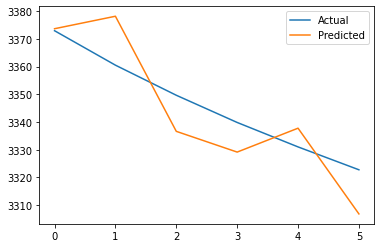

<function matplotlib.pyplot.show>

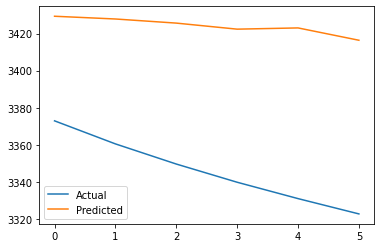

In [170]:
 plt.plot(inv_y,label='Actual')
 plt.plot(inv_yhat,label='Predicted')
 plt.legend()
 plt.show

In [171]:
df4=pd.DataFrame(inv_y,index=Test2.index,columns=['Actual'])
df5 = pd.DataFrame(inv_yhat,index=Test2.index,columns=['Predict'])
df6=Test2['TRM']
df7= pd.concat([df4, df5,df6], axis=1,)
df7

,Actual,Predict,TRM
date,,,
01/02/2020,3372.930420,3373.651123,3277.14
01/03/2020,3360.505615,3378.151123,3258.84
01/07/2020,3349.650635,3336.632324,3262.05
01/08/2020,3339.838867,3329.152344,3264.26
01/09/2020,3331.020996,3337.771240,3254.42
01/10/2020,3322.769287,3306.848633,3253.89


,Actual,Predict,TRM
date,,,
01/02/2020,3372.930420,3429.302490,3277.14
01/03/2020,3360.505615,3427.821289,3258.84
01/07/2020,3349.650635,3425.604248,3262.05
01/08/2020,3339.838867,3422.343506,3264.26
01/09/2020,3331.020996,3423.006836,3254.42
01/10/2020,3322.769287,3416.364014,3253.89


<function matplotlib.pyplot.show>

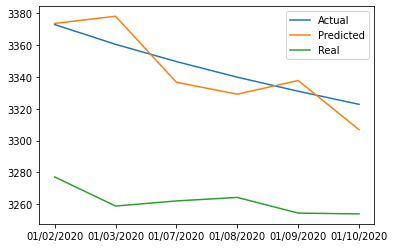

<function matplotlib.pyplot.show>

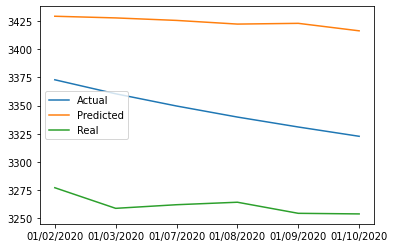

In [172]:
 plt.plot(df7['Actual'],label='Actual')
 plt.plot(df7['Predict'],label='Predicted')
plt.plot(df7['TRM'],label='Real')
 plt.legend()
 plt.show